## Version 4
Getting started with MLflow.

Add autoreload since we are now modifying scripts in other folders.

In [1]:
%load_ext autoreload
%autoreload 2

Getting the data.

In [2]:

import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("/home/vscode/.config/kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)

    with open(config_dir / "kaggle.json", "w") as dst:
        with open("../kaggle.json", "r") as src:
            dst.write(src.read())

In [3]:

import os
import sys

sys.path.append(os.path.abspath(".."))

from ARISA_DSML.config import RAW_DATA_DIR, categorical, target
from ARISA_DSML.preproc import get_raw_data


2025-03-09 09:28:50.949 | INFO     | ARISA_DSML.config:<module>:12 - PROJ_ROOT path is: /workspaces/ARISA-MLOps


In [5]:
from ARISA_DSML.helpers import get_active_branch_name, get_git_commit_hash

get_active_branch_name("..")  # need ".." because we are not in root
get_git_commit_hash()


'a11f84dcabad3d2ddbe5e5b5f2bbee87028a6446'

In [6]:
get_raw_data()
!dir "{RAW_DATA_DIR}"

2025-03-09 09:29:22.654 | INFO     | ARISA_DSML.preproc:get_raw_data:22 - RAW_DATA_DIR is: /workspaces/ARISA-MLOps/data/raw


Dataset URL: https://www.kaggle.com/datasets/wesleyhowe/titanic-labelled-test-set
gender_submission.csv  test.csv  test_augmented.csv  train.csv


Load preproc from preproc.py and run on train data:

In [17]:
from ARISA_DSML.preproc import preprocess_df

train_path = preprocess_df(RAW_DATA_DIR / "train.csv")

In [18]:
train_path

WindowsPath('C:/Users/claus/source/repos/ARISA-MLOps-solutions-L02/data/processed/train.csv')

In [19]:
import pandas as pd

df_train = pd.read_csv(train_path)
df_train["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
 9   Title        891 non-null    object 
 10  Deck         891 non-null    object 
 11  CabinNumber  891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


Split into X and y, get categorical indices:

In [21]:
y_train = df_train.pop(target)
X_train = df_train

categorical_indices = [X_train.columns.get_loc(col) for col in categorical if col in X_train.columns]
categorical_indices

[1, 2, 7, 9, 8]

And run the hyperparameter optimization (if ):

In [23]:
import mlflow
from ARISA_DSML.train import run_hyperopt, get_or_create_experiment

mlflow.set_tracking_uri(f"http://127.0.0.1:5000")

experiment_id = get_or_create_experiment("titanic_hyperparam_tuning")
mlflow.set_experiment(experiment_id=experiment_id)
best_params_path = run_hyperopt(X_train, y_train, categorical_indices)


2025-03-08 21:01:57.671 | INFO     | ARISA_DSML.train:run_hyperopt:72 - Best Parameters: {'depth': 6, 'learning_rate': 0.13758498698037988, 'iterations': 123, 'l2_leaf_reg': 1.5008436219945933, 'bagging_temperature': 0.4926405362869478, 'random_strength': 2.6543483636747336e-05}


Do cross validation again:

In [24]:
import joblib
from ARISA_DSML.train import train_cv
params = joblib.load(best_params_path)
n_folds = 5
cv_output_path = train_cv(X_train, y_train, categorical_indices, params, n=n_folds)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.7706767	test: 0.7633588	best: 0.7633588 (0)	total: 191ms	remaining: 23.3s
1:	learn: 0.7859779	test: 0.7518797	best: 0.7633588 (0)	total: 216ms	remaining: 13.1s
2:	learn: 0.7758945	test: 0.7596899	best: 0.7633588 (0)	total: 247ms	remaining: 9.89s
3:	learn: 0.7748092	test: 0.7656250	best: 0.7656250 (3)	total: 282ms	remaining: 8.39s
4:	learn: 0.7840909	test: 0.7846154	best: 0.7846154 (4)	total: 330ms	remaining: 7.79s
5:	learn: 0.7799228	test: 0.7846154	best: 0.7846154 (4)	total: 364ms	remaining: 7.09s
6:	learn: 0.7880000	test: 0.7656250	best: 0.7846154 (4)	total: 407ms	remaining: 6.74s
7:	learn: 0.8070866	test: 0.7596899	best: 0.7846154 (4)	total: 435ms	remaining: 6.26s
8:	learn: 0.8121442	test: 0.7669173	best: 0.7846154 (4)	total: 463ms	remaining: 5.86s
9:	learn: 0.8140900	test: 0.7480916	best: 0.7846154 (4)	total: 489ms	remaining: 5.53s
10:	learn: 0.8117647	test: 0.7538462	best: 0.7846154 (4)	total: 517ms	remaining: 5.26s
11:	learn: 0.8140900	test: 0.7

And get the performance plots:

In [25]:
from ARISA_DSML.train import plot_error_scatter
cv_results = pd.read_csv(cv_output_path)
plot_error_scatter(
    df_plot=cv_results, 
    name="Mean F1 Score", 
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xtitle="Training Steps",
    ytitle="Performance Score",
    yaxis_range=[0.5, 1]
)

In [26]:
plot_error_scatter(
    cv_results,
    x="iterations",
    y="test-Logloss-mean",
    err="test-Logloss-std",
    name="Mean logloss",
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xtitle="Training Steps",
    ytitle="Logloss",
)


Fit model on full dataset:

In [57]:
from ARISA_DSML.train import train
params = joblib.load(best_params_path)
experiment_id = get_or_create_experiment("titanic_full_training")
mlflow.set_experiment(experiment_id=experiment_id)
model_path, model_params_path = train(X_train, y_train, categorical_indices, params, cv_results=cv_results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6390908	total: 25.9ms	remaining: 3.16s
50:	learn: 0.3372326	total: 1.49s	remaining: 2.1s
100:	learn: 0.3107097	total: 2.94s	remaining: 641ms
122:	learn: 0.2980396	total: 3.56s	remaining: 0us


c:\Users\claus\source\repos\ARISA-MLOps-solutions-L02\.venv\Lib\site-packages\mlflow\types\utils.py:394: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

c:\Users\claus\source\repos\ARISA-MLOps-solutions-L02\.venv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning:

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` modu

And now for the test set, because of our refactor, we don't need to copy paste anymore:

In [32]:
dataset_test_path = RAW_DATA_DIR / "test.csv"
preprocced_test_path = preprocess_df(dataset_test_path)
df_test = pd.read_csv(preprocced_test_path)
df_test["Title"].unique()

df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,CabinNumber
0,892,3,male,34.5,0,0,7.8292,Q,Mr,N,47
1,893,3,female,47.0,1,0,7.0000,S,Mrs,N,47
2,894,2,male,62.0,0,0,9.6875,Q,Mr,N,47
3,895,3,male,27.0,0,0,8.6625,S,Mr,N,47
4,896,3,female,22.0,1,1,12.2875,S,Mrs,N,47


In [33]:
df_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,CabinNumber
0,1,3,male,22.0,1,0,7.2500,S,Mr,N,50
1,2,1,female,38.0,1,0,71.2833,C,Mrs,C,85
2,3,3,female,26.0,0,0,7.9250,S,Miss,N,50
3,4,1,female,35.0,1,0,53.1000,S,Mrs,C,123
4,5,3,male,35.0,0,0,8.0500,S,Mr,N,50


Get predictions and shap plot:

C:\Users\claus\AppData\Local\Temp\ipykernel_6160\1105794690.py:6: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.1/model-registry.html#migrating-from-stages

C:\Users\claus\AppData\Local\Temp\ipykernel_6160\1105794690.py:14: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.1/model-registry.html#migrating-from-stages



2025/03/08 21:06:57 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


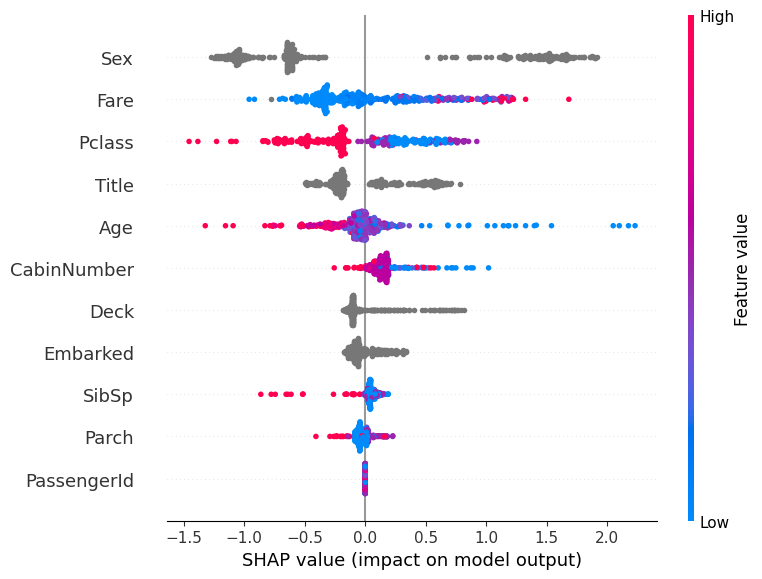

In [ ]:
import json
from ARISA_DSML.predict import predict
from mlflow.client import MlflowClient

client = MlflowClient(mlflow.get_tracking_uri())
model_info = client.get_latest_versions('titanic-surv-bclass')[0]

# extract params/metrics data for run `test_run_id` in a single dict
run_data_dict = client.get_run(model_info.run_id).data.to_dictionary()
run = client.get_run(model_info.run_id)
log_model_meta = json.loads(run.data.tags['mlflow.log-model.history'])
log_model_meta[0]['signature']

latest_model = client.get_latest_versions('titanic-surv-bclass')

_, artifact_folder = os.path.split(latest_model[0].source)
model_uri = "runs:/{}/{}".format(latest_model[0].run_id, artifact_folder)
loaded_model = mlflow.catboost.load_model(model_uri)

params = run_data_dict["params"]
params["feature_columns"] = [inp["name"] for inp in json.loads(log_model_meta[0]['signature']['inputs'])]
preds_path = predict(loaded_model, df_test, params)


And that's it for the Mlflow demo.  

In [59]:
from ARISA_DSML.resolve import get_model_by_alias
client = MlflowClient(mlflow.get_tracking_uri())
champ_mv = get_model_by_alias(client)
chall_mv = get_model_by_alias(client, alias="challenger")

runs:/474b922058b84f099df1dfd25ccc8f93/model


2025/03/08 22:22:39 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


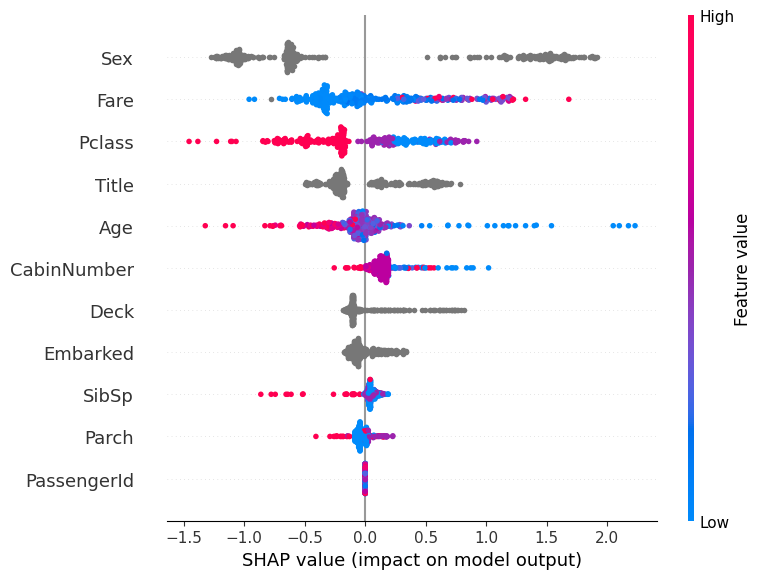

In [80]:
from ARISA_DSML.config import MODEL_NAME
client = MlflowClient(mlflow.get_tracking_uri())
model_info = get_model_by_alias(client, alias="champion")
if model_info is None:
    print("No champion model, predicting using newest model")
    model_info = client.get_latest_versions(MODEL_NAME)[0]

# extract params/metrics data for run `test_run_id` in a single dict 
run_data_dict = client.get_run(model_info.run_id).data.to_dictionary()
run = client.get_run(model_info.run_id)
log_model_meta = json.loads(run.data.tags['mlflow.log-model.history'])
log_model_meta[0]['signature']


_, artifact_folder = os.path.split(model_info.source)
model_uri = "runs:/{}/{}".format(model_info.run_id, artifact_folder)
print(model_uri)
loaded_model = mlflow.catboost.load_model(model_uri)

params = run_data_dict["params"]
params["feature_columns"] = [inp["name"] for inp in json.loads(log_model_meta[0]['signature']['inputs'])]
preds_path = predict(loaded_model, df_test, params)
